In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Cell 1: Project Header & Drive Mount**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


base_path = '/content/drive/MyDrive/aryan.24bcs10336@sst.scaler.com/data/'
gen_file = base_path + 'Plant_1_Generation_Data.csv'
weather_file = base_path + 'Plant_1_Weather_Sensor_Data.csv'

gen_df = pd.read_csv(gen_file)
weather_df = pd.read_csv(weather_file)

print("Files")

Files


In [ ]:
# 1. Date-Time ko computer ke samajhne layak format mein badalna
gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'])
weather_df['DATE_TIME'] = pd.to_datetime(weather_df['DATE_TIME'])



In [ ]:
# 2. Dono ko DATE_TIME par merge (mix) karna
df = pd.merge(gen_df, weather_df, on='DATE_TIME', how='inner')

# 3. Check karna ki data kaisa dikh raha hai
print("Merged Data Shape:", df.shape)
df.head()

Merged Data Shape: (68774, 12)


DATE_TIME  PLANT_ID_x     SOURCE_KEY_x  DC_POWER  AC_POWER  DAILY_YIELD  \
0 2020-05-15     4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0   
1 2020-05-15     4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0   
2 2020-05-15     4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0   
3 2020-05-15     4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0   
4 2020-05-15     4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0   

   TOTAL_YIELD  PLANT_ID_y     SOURCE_KEY_y  AMBIENT_TEMPERATURE  \
0    6259559.0     4135001  HmiyD2TTLFNqkNe            25.184316   
1    6183645.0     4135001  HmiyD2TTLFNqkNe            25.184316   
2    6987759.0     4135001  HmiyD2TTLFNqkNe            25.184316   
3    7602960.0     4135001  HmiyD2TTLFNqkNe            25.184316   
4    7158964.0     4135001  HmiyD2TTLFNqkNe            25.184316   

   MODULE_TEMPERATURE  IRRADIATION  
0           22.857507          0.0  
1           22.857507          0.0  
2           22.857507          0.0  
3           22.857507          0.0  
4           22.857507          0.0

In [ ]:
# Unnecessary columns hatana (Dono files mein Plant ID same hai)
df = df.drop(columns=['PLANT_ID_y'])
df = df.rename(columns={'PLANT_ID_x': 'PLANT_ID'})

# Columns ke naam lowercase ya simple rakhna (optional par recommended)
# Jaise: DC_POWER, AC_POWER, IRRADIATION pehle se hi thik hain.

In [ ]:
# 1. Efficiency nikalna (AC/DC Ratio)
# Note: 0 se divide karne par error na aaye isliye handle karna zaroori hai
df['EFFICIENCY'] = df['AC_POWER'] / df['DC_POWER']
df['EFFICIENCY'] = df['EFFICIENCY'].fillna(0)

# 2. Specific Yield (Power per unit Irradiation)
df['YIELD_PER_IRRADIATION'] = df['DC_POWER'] / df['IRRADIATION']
df['YIELD_PER_IRRADIATION'] = df['YIELD_PER_IRRADIATION'].replace([np.inf, -np.inf], 0).fillna(0)

# 3. Time components extract karna (Seasonality analysis ke liye)
df['HOUR'] = df['DATE_TIME'].dt.hour
df['DAY'] = df['DATE_TIME'].dt.day_name()

print("New Features Created!")
df[['DATE_TIME', 'EFFICIENCY', 'YIELD_PER_IRRADIATION', 'HOUR']].head()

New Features Created!


DATE_TIME  EFFICIENCY  YIELD_PER_IRRADIATION  HOUR
0 2020-05-15         0.0                    0.0     0
1 2020-05-15         0.0                    0.0     0
2 2020-05-15         0.0                    0.0     0
3 2020-05-15         0.0                    0.0     0
4 2020-05-15         0.0                    0.0     0

In [ ]:
print(df.columns)

Index(['DATE_TIME', 'PLANT_ID', 'SOURCE_KEY_x', 'DC_POWER', 'AC_POWER',
       'DAILY_YIELD', 'TOTAL_YIELD', 'SOURCE_KEY_y', 'AMBIENT_TEMPERATURE',
       'MODULE_TEMPERATURE', 'IRRADIATION', 'EFFICIENCY',
       'YIELD_PER_IRRADIATION', 'HOUR', 'DAY'],
      dtype='object')


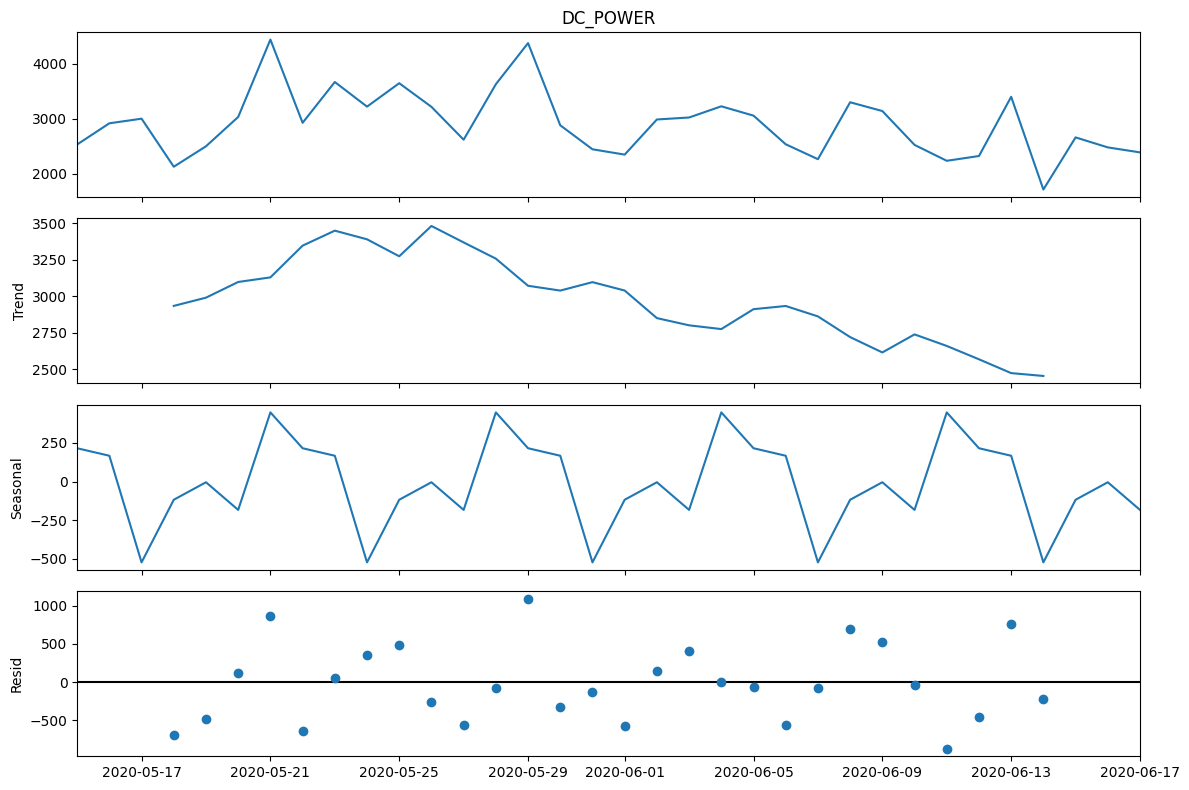

In [ ]:
import statsmodels.api as sm

# 1. Ek specific inverter ko chunna (SOURCE_KEY_x use kar rahe hain)
sample_inverter = df['SOURCE_KEY_x'].unique()[0]
inverter_df = df[df['SOURCE_KEY_x'] == sample_inverter].copy()

# 2. DATE_TIME ko index banana (Time series ke liye zaroori hai)
inverter_df.set_index('DATE_TIME', inplace=True)

# 3. Daily average nikalna (Har din ka ek point)
daily_data = inverter_df['DC_POWER'].resample('D').mean().fillna(0)

# 4. Decomposition: Trend aur Seasonality ko alag karna
# Period 7 rakha hai kyunki hum weekly trend dekhna chahte hain
result = sm.tsa.seasonal_decompose(daily_data, model='additive', period=7)

# 5. Sirf Trend aur Seasonality plot karna
plt.rcParams['figure.figsize'] = (12, 8)
result.plot()
plt.show()

In [ ]:
from sklearn.ensemble import IsolationForest

# 1. Sirf zaroori features ko chunn-na analysis ke liye
features = ['DC_POWER', 'IRRADIATION', 'MODULE_TEMPERATURE']
data_for_model = df[features].fillna(0)

# 2. Model setup karna (Contamination 0.05 matlab humein 5% data abnormal lag raha hai)
model = IsolationForest(contamination=0.05, random_state=42)

# 3. Anomalies predict karna (-1 ka matlab anomaly, 1 ka matlab normal)
df['is_anomaly'] = model.fit_predict(data_for_model)

# 4. Kitni anomalies mili check karein
print(df['is_anomaly'].value_counts())

is_anomaly
 1    65335
-1     3439
Name: count, dtype: int64


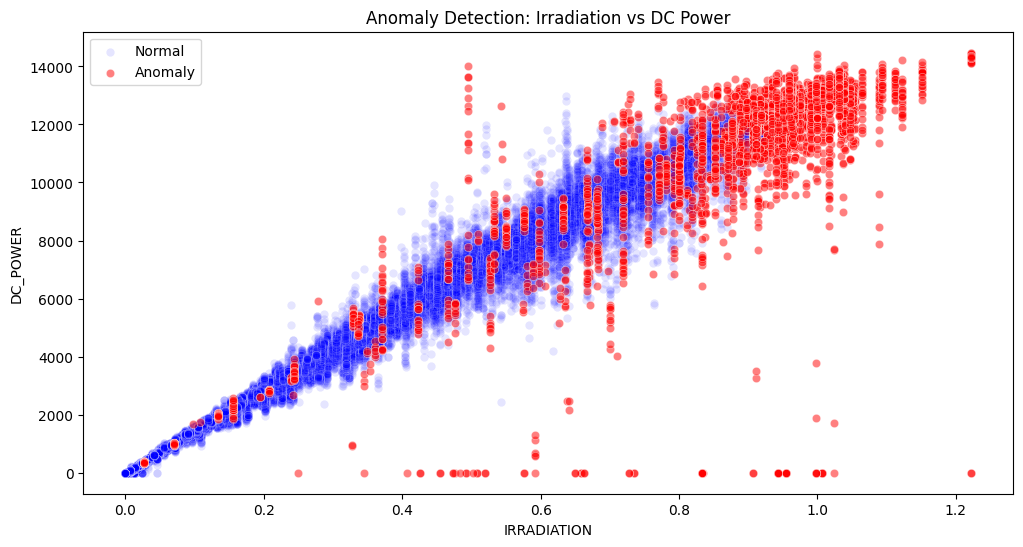

In [ ]:
plt.figure(figsize=(12, 6))

# 1. Normal points ko blue color mein dikhana
sns.scatterplot(data=df[df['is_anomaly'] == 1],
                x='IRRADIATION', y='DC_POWER',
                color='blue', label='Normal', alpha=0.1)

# 2. Anomaly points ko red color mein dikhana taaki wo alag se dikhein
sns.scatterplot(data=df[df['is_anomaly'] == -1],
                x='IRRADIATION', y='DC_POWER',
                color='red', label='Anomaly', alpha=0.5)

plt.title('Anomaly Detection: Irradiation vs DC Power')
plt.legend()
plt.show()

/tmp/ipython-input-3169342325.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=anomalies_only, x='HOUR', palette='viridis')


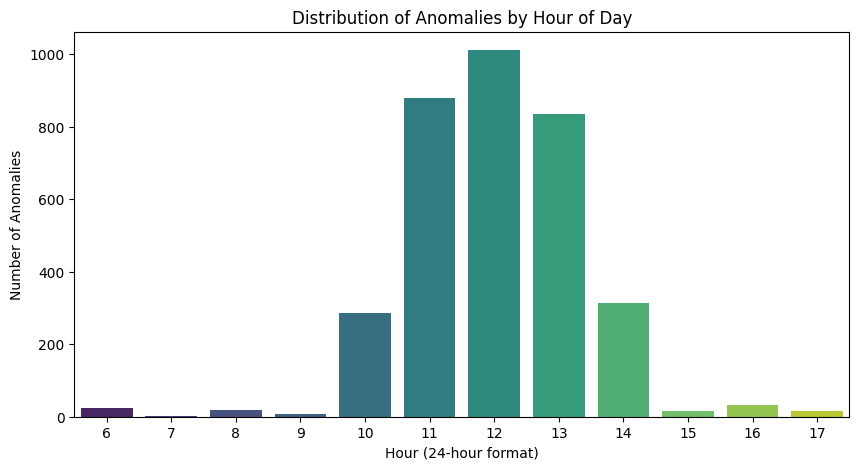

In [ ]:
# 1. Sirf anomalies (-1) wala data filter karna
anomalies_only = df[df['is_anomaly'] == -1]

# 2. Ghante ke hisaab se anomalies ka count plot karna
plt.figure(figsize=(10, 5))
sns.countplot(data=anomalies_only, x='HOUR', palette='viridis')
plt.title('Distribution of Anomalies by Hour of Day')
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Number of Anomalies')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# 1. Inverters ke hisaab se data ko group karna
# Hum har inverter ki average efficiency aur total yield nikal rahe hain
inverter_summary = df.groupby('SOURCE_KEY_x').agg({
    'EFFICIENCY': 'mean',
    'DAILY_YIELD': 'mean',
    'DC_POWER': 'mean'
}).reset_index()

# 2. Data ko scale karna (Clustering ke liye zaroori hai)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(inverter_summary[['EFFICIENCY', 'DAILY_YIELD', 'DC_POWER']])

# 3. K-Means++ model chalana (Hum 3 clusters bana rahe hain: Good, Average, Poor)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
inverter_summary['cluster'] = kmeans.fit_predict(scaled_features)

# 4. Result dekhna
print("Inverter Clusters Assigned!")
inverter_summary.head()

Inverter Clusters Assigned!


SOURCE_KEY_x  EFFICIENCY  DAILY_YIELD     DC_POWER  cluster
0  1BY6WEcLGh8j5v7    0.051405  3230.658151  2873.720981        1
1  1IF53ai7Xc0U56Y    0.052431  3356.162374  3225.125523        0
2  3PZuoBAID5Wc2HD    0.052367  3356.856357  3221.015673        0
3  7JYdWkrLSPkdwr4    0.052338  3325.810327  3132.891955        2
4  McdE0feGgRqW7Ca    0.052425  3321.935705  3211.307245        2

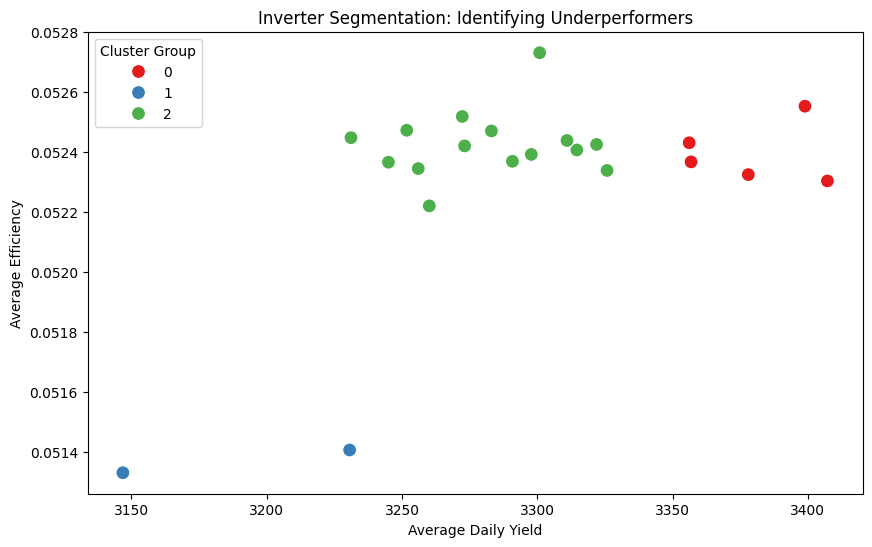

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=inverter_summary, x='DAILY_YIELD', y='EFFICIENCY',
                hue='cluster', palette='Set1', s=100)
plt.title('Inverter Segmentation: Identifying Underperformers')
plt.xlabel('Average Daily Yield')
plt.ylabel('Average Efficiency')
plt.legend(title='Cluster Group')
plt.show()